# Манитное склонение

In [214]:
# Enter values here
original_year = 2006
original_value = 1.6
change_per_year = 0.2

In [215]:
import datetime
current_year = datetime.datetime.now().year

d = original_value + change_per_year * (current_year - original_year)
d

4.4

# Девиация
## Таблица

In [216]:
import pandas as pd

sigma_table = pd.read_csv('deviation.csv', header=None, names=["Compass Course", "Deviation"])
sigma_table

,Compass Course,Deviation
0,0,-2.5
1,10,-0.5
2,20,1.6
3,30,4.4
4,40,7.6
5,50,11.1
6,60,14.0
7,70,16.5
8,80,18.7
9,90,20.1


In [217]:
def _assert_course(course):
    assert course < 360, "Course value should be less than 360 degrees"

def _normalize(course):
    course = course % 360
    if course < 0:
        course = 360 + course
    return course

def deviation_for_cc(compass_course):
    """
    Calculate deviation for the given compass course.

    :param compass_course: in degrees
    :return: deviation rounded to 2 decimal digits
    """
    _assert_course(compass_course)
    cell_index = compass_course // 10
    next_cell_index = (cell_index + 1) % sigma_table.shape[0]
    remainder = compass_course % 10

    sigma = sigma_table.Deviation[cell_index] + (sigma_table.Deviation[next_cell_index] - sigma_table.Deviation[cell_index]) / 10 * remainder
    return round(sigma, 2)

In [218]:
SIGMA = 0.015
MAX_ITERATIONS = 30

def deviation_for_mc(magnetic_course):
    _assert_course(magnetic_course)

    # print("Magnetic: {}".format(magnetic_course))
    compass_course = magnetic_course
    last_dev = 360

    for i in range(MAX_ITERATIONS):
        dev = deviation_for_cc(compass_course)

        if abs(last_dev - dev) <= SIGMA:
            return dev

        compass_course = _normalize(magnetic_course + dev)
        last_dev = dev
        # print("Deviation: {} Corrected course: {}".format(dev, compass_course))

    raise Exception("Iteration limit exceeded, but deviation is still not found")

# Deviation Plots for Compass and Magnetic Courses

Text(0.5, 1.05, 'Deviation for Magnetic Course')

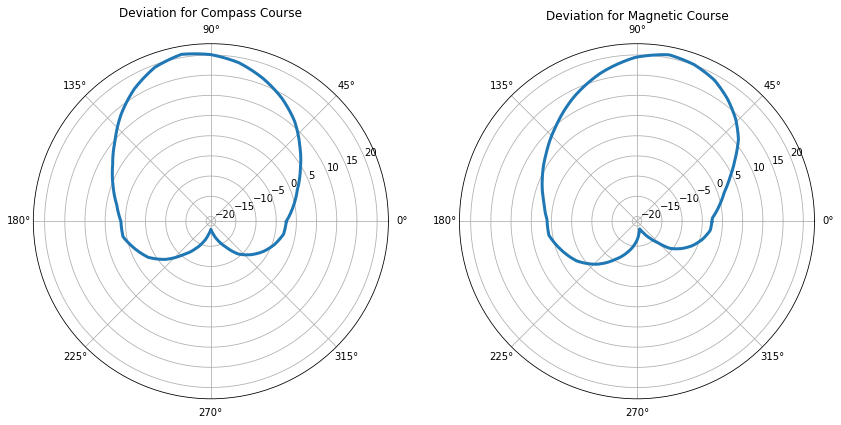

In [219]:
import matplotlib.pyplot as plt
from math import radians

courses = list(range(360))
rad = [radians(x) for x in courses]

ax0 = plt.subplot(121, projection='polar')
ax0.figure.set_size_inches(14, 7)
ax0.plot(rad, [deviation_for_cc(x) for x in courses], linewidth=3.0)
ax0.set_title('Deviation for Compass Course', va='bottom')

ax1 = plt.subplot(122, projection='polar')
ax1.plot(rad, [deviation_for_mc(x) for x in courses], linewidth=3.0)
ax1.set_title('Deviation for Magnetic Course')

In [220]:
def mc_from_cc(compass_course):
    """
    Find magnetic course from compass course.

    :param compass_course: in degrees
    :return: magnetic course
    """
    sigma = deviation_for_cc(compass_course)

    # TODO: normalize

    return compass_course + sigma

deviation_for_cc(315)


-9.45